In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DLP/DLP_autoXRD/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DLP/DLP_autoXRD


# Dependencies

In [2]:
# Loads series of functions for preprocessing and data augmentation
from autoXRD import *
# Loads CAMs visualizations for a-CNN
from autoXRD_vis import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score

# Neural networks uses Keran with TF background
import keras as K
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras


# loading data

THeoretical data:

In [3]:
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
theor = theor.iloc[1:,]
theor_arr=theor.values

# Normalize data for training
ntheor = normdata(theor_arr)

# Load labels for simulated data
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

In [4]:
ntheor.shape

(2125, 164)

Experimental data:

In [5]:
# Load experimental data as dataframe
exp_arr_new = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr_new = exp_arr_new.values

# Load experimental class labels
label_exp= pd.read_csv('Datasets/label_exp.csv', index_col=0).values
label_exp = label_exp.reshape([len(label_exp),])

# Load class enconding
space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

# Normalize experimental data
nexp = normdata(exp_arr_new)

# Define spectral range for data augmentation
exp_min = 0
exp_max = 1200
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))

In [6]:
post_exp.shape

(1200, 88)

In [7]:
ntheor.shape

(2125, 164)

# Data augmentation

In [55]:
################################################################
# Perform data augmentation
################################################################

# Specify how many data points we augmented
th_num = 2000

# Augment data, this may take a bit
augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

# Enconde theoretical labels
label_t=np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i]=space_group_enc.index(pard[i])

# Input the num of experimetal data points
exp_num = 2000
exp_x, exp_y = exp_augdata(post_exp, exp_num ,label_exp)

test_size = 250

split = test_size / exp_num

# Prepare experimental arrays for training and testing
exp_x = np.transpose(exp_x[:,0:exp_num])
exp_y = exp_y[0:exp_num]

X_exp, X_test, y_exp, y_test = train_test_split(exp_x, exp_y, test_size=split, random_state=42)

# Prepare simulated arrays for training and testing
X_th = np.transpose(crop_augd )
y_th = label_t


In [56]:
X_exp.shape

(1750, 1200)

In [57]:
x = np.concatenate((X_exp, X_th), axis=0)
y = np.concatenate((y_exp, y_th), axis=0)

#split  data to reserve some test data
x_train, y_train = x, y


In [81]:
unique, counts = np.unique(y_train, return_counts=True)

data = {
    'Space group label': space_group_enc,
    'Counts in training dataset': counts
}

df = pd.DataFrame(data)


In [82]:
df

,Space group label,Counts in training dataset
0,Fm-3m,790
1,I41mcm,397
2,P21a,392
3,P3m1,482
4,P61mmc,248
5,Pc,121
6,Pm-3m,1320


from matplotlib import pyplot as plt
df['Counts in training dataset'].plot(kind='hist', bins=20, title='Counts in training dataset')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Space group label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Counts in training dataset'].plot(kind='line', figsize=(8, 4), title='Counts in training dataset')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Space group label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Counts in training dataset', y='Space group label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Data preparation

In [58]:

def data_prep():
    enc = OneHotEncoder()

    train_dim = x_train.reshape(x_train.shape[0],1200,1)
    train_y = y_train
    train_y_hot = enc.fit_transform(train_y.reshape(-1,1)).toarray()  # Convert to dense array

    # Define test data
    test_x = X_test.reshape(X_test.shape[0],1200,1)
    test_y = enc.fit_transform(y_test.reshape(-1,1)).toarray()

    if isinstance(train_y_hot, tf.sparse.SparseTensor):
        train_y_hot = tf.sparse.to_dense(train_y_hot)

    return train_dim, train_y_hot, test_x, test_y

train_dim, train_y_hot, test_x, test_y = data_prep()


# Defining different models

below you can write a function where we define specific models which can be loaded, evaluated and for which we can plot a confusion matrix

## CNN model

In [18]:

# Define network structure
def a_cnn_model(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## CNN model with batchnorm

I experimented with a CNN model which has batchnorm but I found that only 1 batchnorm layer works the best

In [83]:

# Define network structure
def batchnorm_model(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## CNN with batchnorm with a different optimizer

In [20]:

# Define network structure
def batchnorm_model_sgd(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.SGD(learning_rate = 0.1, momentum=0.01)

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

# Decision tree

In [21]:
import xgboost as xgb
def decision_tree(train_dim, train_y_hot):

    # Convert one-hot encoding to class indices
    #have to convert one hot back to indices
    y_train = np.argmax(train_y_hot, axis=1)
    x_training = train_dim.reshape(train_dim.shape[0], -1)
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(x_training, label=y_train)
    # dtest = xgb.DMatrix(X_test, label=y_test)

    # XGBoost parameters for multiclass classification
    params = {
        "objective": "multi:softmax",  # Multi-class classification
        "num_class": 7,  # Number of classes
        "eval_metric": "mlogloss",  # Multi-class log loss
    }

    # Train the model
    num_round = 100  # Number of boosting rounds
    model = xgb.train(params, dtrain, num_round)

    return model

# Confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def conf_matrix(model):
    prediction = model.predict(test_x)
    # For a classification task, convert predictions to class labels (if needed)
    prediction_ord=[np.argmax(element) for element in prediction]


    # If your true labels are one-hot encoded, you may need to convert them as well
    true_labels = [np.argmax(element) for element in test_y]

    cm = confusion_matrix(true_labels, prediction_ord, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
    disp.plot()
    plt.show()
    return None

## Transformers

This code is shamelessly generated by my favorite transformer dr. GPT

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

# Transformer Encoder Block
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Positional Encoding (since Transformers lack inherent position awareness)
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super().__init__()
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        return inputs + self.position_embeddings(positions)

# Define the full Transformer model
def build_transformer_model(seq_length, embed_dim, num_heads, ff_dim, num_classes):
    inputs = layers.Input(shape=(seq_length, 1))  # XRD spectra as sequences
    x = layers.Conv1D(embed_dim, kernel_size=3, padding="same", activation="relu")(inputs)  # Learn embeddings
    x = PositionalEncoding(seq_length, embed_dim)(x)

    # Stack Transformer Encoder blocks
    for _ in range(2):  # Number of Transformer layers
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)  # Aggregate features
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)  # Classification output

    model = keras.Model(inputs, outputs)
    return model

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 1200, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 1200, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_4                │ (None, 1200, 64)            │          76,800 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_8                │ (None, 1200, 64)            │          83,200 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_9                │ (None, 1200, 64)            │          83,200 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,911 (952.78 KB)

 Trainable params: 243,911 (952.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_transformer(train_dim, train_y_hot, test_x, test_y):
    # Hyperparameters
    seq_length = train_dim.shape[1]
    embed_dim = 64  # Feature size
    num_heads = 4  # Number of attention heads
    ff_dim = 128  # Feedforward layer size
    # num_classes = len(np.unique(y_train))
    num_classes = 7

    # Build and compile the model
    transformer_model = build_transformer_model(seq_length, embed_dim, num_heads, ff_dim, num_classes)
    transformer_model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"]
    )

    transformer_model.summary()
    hist = transformer_model.fit(train_dim, train_y_hot, batch_size=128, epochs=100,
                        verbose=1, validation_data =(test_x, test_y))

    return tranformer_model, hist

# Training different models

## CNN

In [71]:
train_dim, train_y_hot, test_x, test_y = data_prep()
cnn_model, cnn_hist = a_cnn_model(train_dim, train_y_hot, test_x, test_y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - categorical_accuracy: 0.3269 - loss: 0.6788 - val_categorical_accuracy: 0.6160 - val_loss: 0.5281
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.3462 - loss: 0.4889 - val_categorical_accuracy: 0.6160 - val_loss: 0.3434
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.3414 - loss: 0.3748 - val_categorical_accuracy: 0.6160 - val_loss: 0.3145
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - categorical_accuracy: 0.3419 - loss: 0.3726 - val_categorical_accuracy: 0.6160 - val_loss: 0.3100
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.3506 - loss: 0.3678 - val_categorical_accuracy: 0.6160 - val_loss: 0.3046
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - categorical_accuracy: 0.3596 - loss: 0.3587 - val_categorical_accuracy: 0.6400 - val_loss: 0.2785
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - categorical_accuracy: 0.3829 - loss

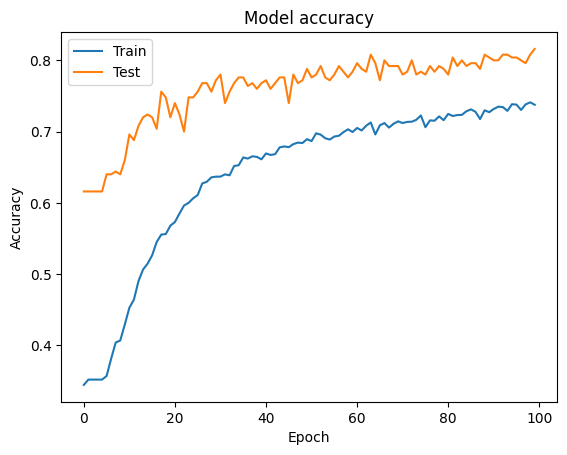

In [97]:
plt.plot(cnn_hist.history['categorical_accuracy'])
plt.plot(cnn_hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## CNN with batchnorm

In [87]:
cnn_batchnorm_model, batchnorm_hist = batchnorm_model(train_dim, train_y_hot, test_x, test_y)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - categorical_accuracy: 0.2451 - loss: 0.6880 - val_categorical_accuracy: 0.0200 - val_loss: 0.6683
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.5144 - loss: 0.6046 - val_categorical_accuracy: 0.0080 - val_loss: 0.6604
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5885 - loss: 0.5365 - val_categorical_accuracy: 0.0080 - val_loss: 0.6243
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.6261 - loss: 0.4587 - val_categorical_accuracy: 0.0080 - val_loss: 0.5738
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.6390 - loss: 0.3850 - val_categorical_accuracy: 0.0080 - val_loss: 0.5293
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.6807 - loss: 0.3206 - val_categorical_accuracy: 0.0080 - val_loss: 0.5097
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.6884 - loss: 0.2

In [94]:
batchnorm_hist.history.keys()

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])

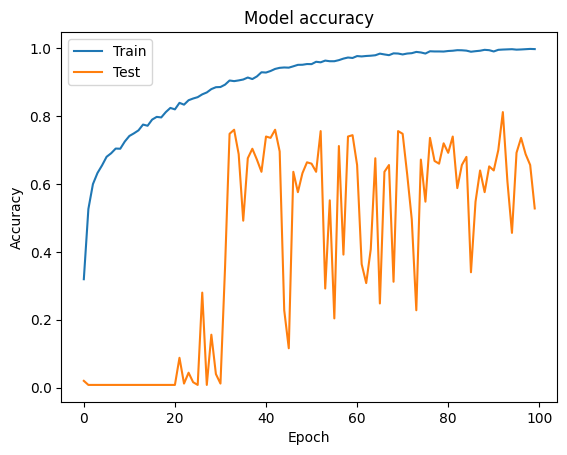

In [95]:
plt.plot(batchnorm_hist.history['categorical_accuracy'])
plt.plot(batchnorm_hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## CNN batchnorm with SGD

In [86]:
sgd_cnn, sgd_hist = batchnorm_model_sgd(train_dim, train_y_hot, test_x, test_y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - categorical_accuracy: 0.1589 - loss: 0.6834 - val_categorical_accuracy: 0.6160 - val_loss: 0.6069
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3398 - loss: 0.5840 - val_categorical_accuracy: 0.6160 - val_loss: 0.4922
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3554 - loss: 0.4607 - val_categorical_accuracy: 0.6160 - val_loss: 0.3676
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3495 - loss: 0.3815 - val_categorical_accuracy: 0.6160 - val_loss: 0.3332
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.3439 - loss: 0.3721 - val_categorical_accuracy: 0.6160 - val_loss: 0.3309
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.3449 - loss: 0.3679 - val_categorical_accuracy: 0.6160 - val_loss: 0.3311
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - categorical_accuracy: 0.3481 - loss: 0

## Decision tree

In [62]:
model_tree = decision_tree(train_dim, train_y_hot)

## transformer

In [ ]:
transformer_model = build_transformer(train_dim, train_y_hot, test_x, test_y)

# Evaluating the models

## CNN

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7682 - loss: 0.1558 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


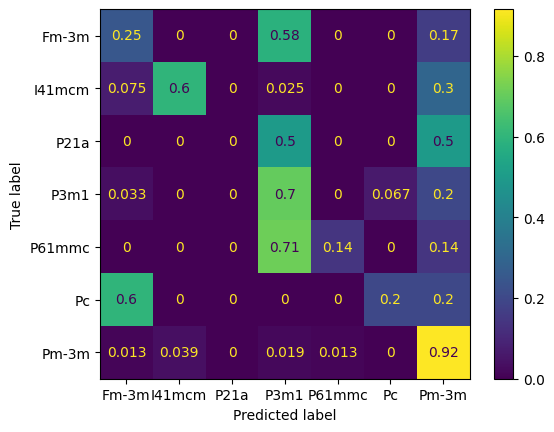

In [67]:
cnn_model.evaluate(test_x, test_y, return_dict = True)
conf_matrix(cnn_model)

## CNN with batchnorm

Only 1 batchnorm layer. Works the best for me

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


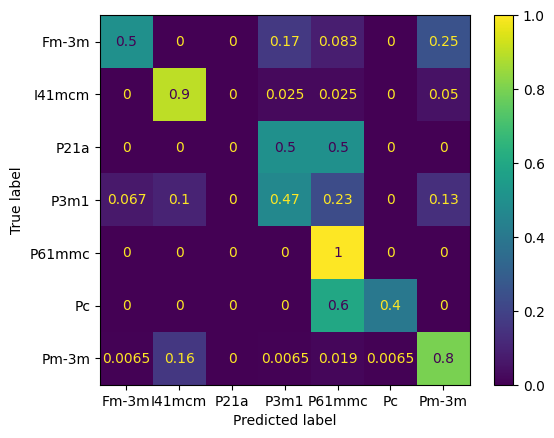

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - categorical_accuracy: 0.7744 - loss: 0.2923


{'categorical_accuracy': 0.7519999742507935, 'loss': 0.29038846492767334}

In [85]:
conf_matrix(cnn_batchnorm_model)
cnn_batchnorm_model.evaluate(test_x, test_y, return_dict = True)

## Decision tree

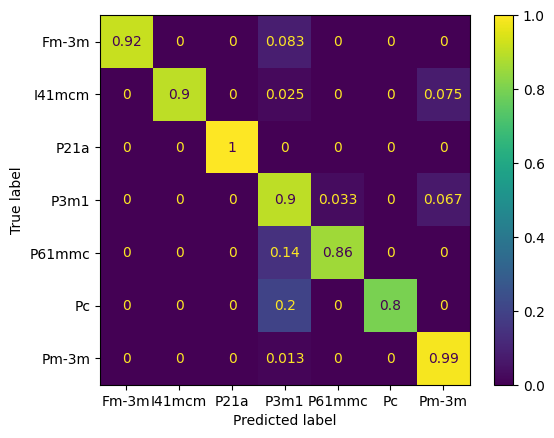

Accuracy: 0.952


In [69]:
from sklearn.metrics import accuracy_score

dtest = xgb.DMatrix(X_test, label=y_test)

y_pred = model_tree.predict(dtest)

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
disp.plot()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

## CNN with batchnorm and SGD optimizer

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


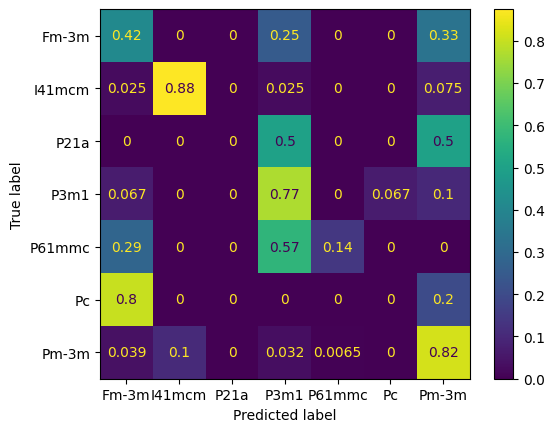

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7535 - loss: 0.1892 


{'categorical_accuracy': 0.7599999904632568, 'loss': 0.1907568722963333}

In [70]:
conf_matrix(sgd_cnn)
sgd_cnn.evaluate(test_x, test_y, return_dict = True)

## Transformer

In [ ]:
conf_matrix(transformer_model)
transformer_model.evaluate(test_x, test_y, return_dict = True)